<a href="https://colab.research.google.com/github/dyoni2/jiyeon/blob/main/8_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**이미지 분석을 위한 합성곱 신경망 모델 이용**

합성곱 신경망에서 필터는 이미지에 있는 어떤 특징을 찾는다고 생각할 수 있음

처음에는 간단한 기본적인 특징 (직선, 곡선 등)을 찾고 층이 깊어질수록 다양하고 구체적인 특징을 감지할 수 있도록 필터의 개수를 늘림

또한 어떤 특징이 이미지의 어느 위치에 놓이더라도 쉽게 감지할 수 있도록 너비와 높이 차원을 점점 줄여나감

자세한 것은 다음 절들을 통해 직접 이해할 수 있음

**완전 연결 신경망 vs. 합성곱 신경망**

완전 연결 신경망에서는 입력 이미지를 밀집층에 연결하기 위해 일렬로 펼쳐야 했으나 합성곱 신경망에서는 2차원 이미지를 그대로 이용하므로 펼치지 않음

다만 입력 이미지는 항상 깊이(채널)이 있어야 하므로 채널 차원을 추가함

In [1]:
from tensorflow import keras
from sklearn.model_selection import train_test_split

(train_input, train_target), (test_input, test_target) = \
    keras.datasets.fashion_mnist.load_data()

train_scaled = train_input.reshape(-1, 28, 28, 1) / 255.0

train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, train_target, test_size=0.2, random_state=42)

4422102/4422102 [==============================] - 0s 0us/step


## 합성곱 신경망 만들기

In [2]:
model = keras.Sequential()
model.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu',
                              padding='same', input_shape=(28,28,1)))
model.add(keras.layers.MaxPooling2D(2))

두 번째 합성곱 층 + 완전 연결 층

과대적합을 막기 위해 드롭아웃을 추가

In [3]:
model.add(keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu',
                              padding='same'))
model.add(keras.layers.MaxPooling2D(2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(10, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 100)               3

**모델 파라미터 수를 계산해보자**

첫 번째 합성곱 층은 (33,1) 크기의 32개의 필터를 가지고 있음. 필터마다 하나의 절편이 추가됨

따라서 3* 3* 1*32+ 32= 320

두 번째 합성곱 층은 (3.3,32) 크기의 64개의 필터를 가지고 있음. 필터마다 하나의 절편이 추가됨

따라서 3*3*32* 64+ 64= 18496

Flatten 층에서 (7.7.64) 크기의 특성 맵을 1차원 배열로 펼치면 7*7* 64= 3136 크기의 배열이 됨

이를 100개의 뉴런과 완전히 연결해야 하므로 은닉층의 모델 파라미터 개수는 3136* 100+ 100= 313700

마지막 출력 층은 100* 10+ 10= 1010


---


**층의 구성을 그림으로 표현해보자**

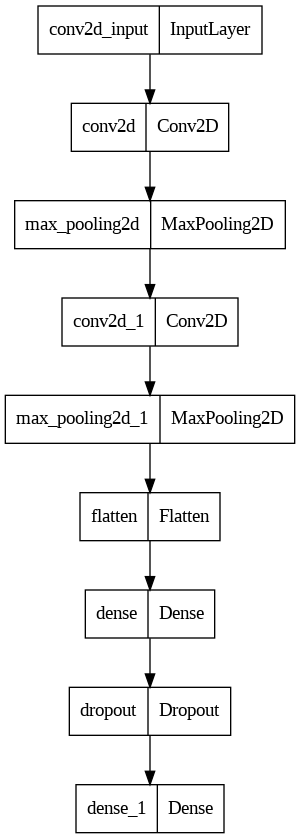

In [4]:
keras.utils.plot_model(model)

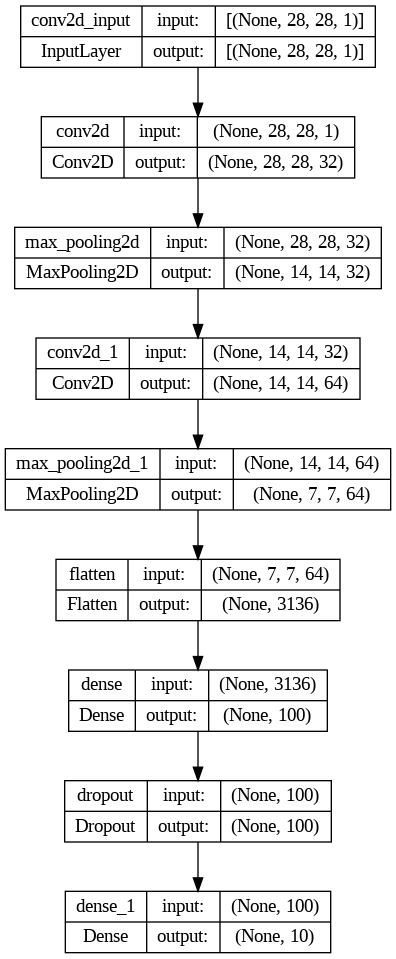

In [5]:
keras.utils.plot_model(model, show_shapes=True)

## 모델 컴파일과 훈련

In [6]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics='accuracy')

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-cnn-model.h5',
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,
                                                  restore_best_weights=True)

history = model.fit(train_scaled, train_target, epochs=20,
                    validation_data=(val_scaled, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/20
1500/1500 [==============================] - 18s 5ms/step - loss: 0.5290 - accuracy: 0.8108 - val_loss: 0.3285 - val_accuracy: 0.8782
Epoch 2/20
  32/1500 [..............................] - ETA: 4s - loss: 0.3524 - accuracy: 0.8721

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1500/1500 [==============================] - 6s 4ms/step - loss: 0.3477 - accuracy: 0.8756 - val_loss: 0.2732 - val_accuracy: 0.8969
Epoch 3/20
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2934 - accuracy: 0.8942 - val_loss: 0.2618 - val_accuracy: 0.9007
Epoch 4/20
1500/1500 [==============================] - 7s 4ms/step - loss: 0.2638 - accuracy: 0.9044 - val_loss: 0.2366 - val_accuracy: 0.9114
Epoch 5/20
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2414 - accuracy: 0.9111 - val_loss: 0.2336 - val_accuracy: 0.9136
Epoch 6/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2204 - accuracy: 0.9197 - val_loss: 0.2249 - val_accuracy: 0.9152
Epoch 7/20
1500/1500 [==============================] - 8s 5ms/step - loss: 0.2038 - accuracy: 0.9241 - val_loss: 0.2264 - val_accuracy: 0.9202
Epoch 8/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.1896 - accuracy: 0.9292 - val_loss: 0.2207 - val_accuracy: 0.9182
Epo

케라스 API는 딥러닝 모델의 종류나 구성 방식에 상관없이 컴파일과 훈련 과정이 같다는 장점을 가짐

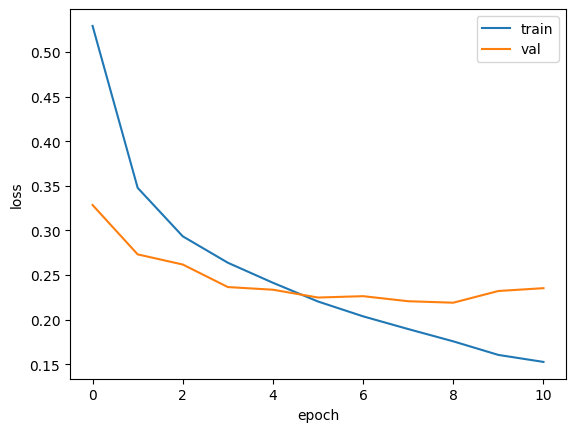

In [7]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

In [8]:
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 2ms/step - loss: 0.2191 - accuracy: 0.9208


[0.21907499432563782, 0.9208333492279053]

첫 번째 검증 데이터를 확인해보자

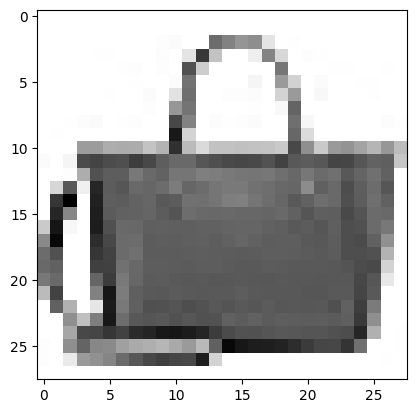

In [9]:
plt.imshow(val_scaled[0].reshape(28, 28), cmap='gray_r')
plt.show()

첫 번째 검증 데이터를 예측해보자

In [10]:
preds = model.predict(val_scaled[0:1])
print(preds)

1/1 [==============================] - 0s 259ms/step
[[2.19641417e-17 8.98017565e-21 2.88303334e-20 2.83726440e-20
  1.06058195e-17 3.70209514e-15 5.11949678e-16 1.20235107e-18
  1.00000000e+00 2.88684684e-16]]


**슬라이싱한 이유**

predict() 메서즈에 데이터를 전달할 때 val_scaled[0]가 아닌 val_scaled[0:1]와 같이 슬라이싱함

그 이유는 케라스의 fit(), predict(), evaluate() 메서드는 모두 입력의 첫 번째 차원이 배치 차원으로 생각하기 때문임

따라서 샘플 하나를 전달할 때는 (28,28.1)이 아니라 (1,28,28.1) 크기를 전달해야함

배열 슬라이싱은 인덱싱과 다르게 선택된 원소가 하나이더라도 전체 차원이 유지되어 (1,28,28,1)크기를 만듦

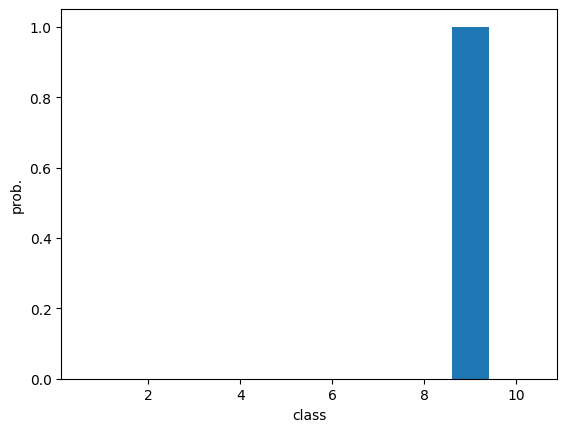

In [11]:
plt.bar(range(1, 11), preds[0])
plt.xlabel('class')
plt.ylabel('prob.')
plt.show()

In [13]:
classes = ['티셔츠', '바지', '스웨터', '드레스', '코트',
           '샌달', '셔츠', '스니커즈', '가방', '앵클 부츠']
import numpy as np
print(classes[np.argmax(preds)])

가방


테스트 샘플에 대한 예측 수행

In [14]:
test_scaled = test_input.reshape(-1, 28, 28, 1) / 255.0
model.evaluate(test_scaled, test_target)

313/313 [==============================] - 2s 5ms/step - loss: 0.2451 - accuracy: 0.9171


[0.24510295689105988, 0.9171000123023987]